# Step1. 검증용 데이터셋 준비

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
import cv2       
from tensorflow.keras import layers
from IPython import display
from pytesseract import Output
import matplotlib.pyplot as plt

17개의 이미지를 준비하였다.

In [7]:
img_dir = os.getenv('HOME')+'/aiffel/ocr_python/images'
file_list = os.listdir(img_dir)
file_list.sort()
file_list

['1.jpg',
 '10.jpg',
 '11.jpg',
 '12.jpg',
 '13.jpg',
 '14.jpg',
 '15.jpg',
 '16.jpg',
 '17.jpg',
 '2.jpg',
 '3.jpg',
 '4.jpg',
 '5.jpg',
 '6.jpg',
 '7.jpg',
 '8.jpg',
 '9.jpg']

- 한국어와 영어가 같이 있는 텍스트
- 한국어만 있는 텍스트
- 영어만 있는 텍스트
- 기울어진 텍스트
- 회전된 텍스트
- 직접 쓴 글씨/타이핑한 글씨
등등

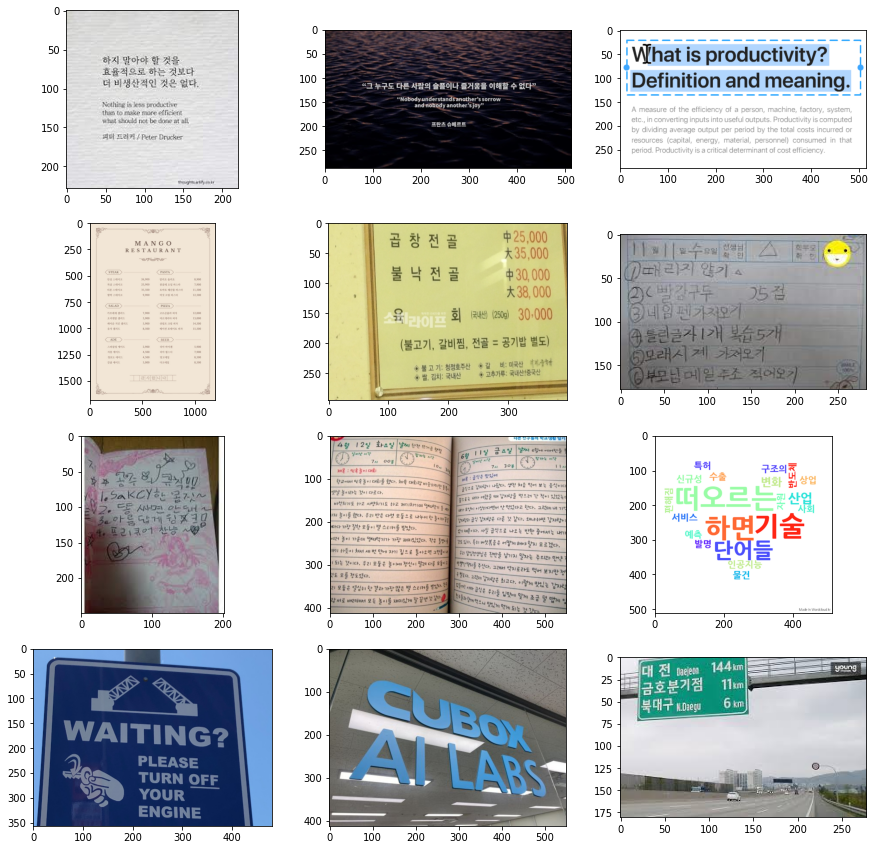

In [13]:
plt.figure(figsize=(15,15))
for i in range(12):
    plt.subplot(4, 3, i+1)
    img = cv2.imread(os.path.join(img_dir, file_list[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
plt.show()

# Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

## 1) Google OCR API

In [14]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [5]:
# # 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# # 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'


# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for file in file_list:
    path = os.path.join(img_dir, file)
    print(path)
    detect_text(path)

total 6516
drwxr-xr-x 2 root root    4096 Sep 22 01:45  cropped
-rw-r--r-- 1 root root 3222808 Sep 22 00:28 '[E_18]OCR (1).ipynb'
-rw-r--r-- 1 root root 2453850 Sep 23 00:30 '[E_18]OCR.ipynb'
-rw-r--r-- 1 root root  977178 Sep 22 01:58 '[E-18]다양한 OCR모델 비교하기.ipynb'
drwxr-xr-x 2 root root    4096 Sep 23 00:29  images
-rw-r--r-- 1 root root    2336 Sep 22 00:26  my_google_api_key.json
/aiffel/aiffel/ocr_python/images/1.jpg
Texts:

"하지 말아야 할 것을
효율적으로 하는 것보다
더 비생산적인 것은 없다.
Nothing is less productive
than to make more efficient
what should not be done at all.
H selA/ Peter Drucker
"

"하지"

"말아야"

"할"

"것을"

"효율적"

"으로"

"하는"

"것"

"보다"

"더"

"비생산적인"

"것은"

"없다"

"."

"Nothing"

"is"

"less"

"productive"

"than"

"to"

"make"

"more"

"efficient"

"what"

"should"

"not"

"be"

"done"

"at"

"all."

"H"

"selA/"

"Peter"

"Drucker"
bounds: (120,159),(149,159),(149,166),(120,166)
/aiffel/aiffel/ocr_python/images/10.jpg
Texts:

"“그 누구도 다른 사람의 슬픔이나 즐거움을 이해할 수 없다”
“Nobody understandsanother's so

- 타이핑한 글씨에 대해서는 한글, 영어 모두 적절하게 인식한다.
- 하지만 띄어쓰기나 특수문자가 종종 이상하다. 한자를 특수문자로 인식했다.
- 텍스트가 아닌 것(구분칸 등)도 텍스트로 인식한다.
- 직접 쓴 글씨의 경우 정확도가 더 떨어졌다. 한글, 영어와 숫자를 서로 잘 혼동하는 것 같다.
- 회전한 텍스트도 잘 인식한다.

## 2) keras-ocr

인식을 위한 파이프라인 생성

In [15]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [16]:
file_list2 = ['1.jpg',
 '10.jpg',
 '11.jpg',
 '12.jpg',
 '13.jpg',
 '14.jpg',
 '15.jpg',
 '16.jpg',
 '17.jpg',
 '2.jpg',
 '3.jpg',
 '4.jpg',
 '5.jpg',
 '6.jpg']
# 8번 이미지를 넣으면 오류가 발생해서 제외.

파이프라인 recognize()에 이미지를 넣어준다.

In [17]:
images = [keras_ocr.tools.read(os.path.join(img_dir, file)) for file in file_list2]
prediction_groups = [pipeline.recognize([os.path.join(img_dir, file)]) for file in file_list2]

주의)
- keras-ocr은 한글 데이터셋으로 훈련이 되어있지 않은 모델이므로
- 한글 텍스트의 detection은 정상적으로 진행되더라도 recognition 결과가 엉뚱하게 나올 수 있다.

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


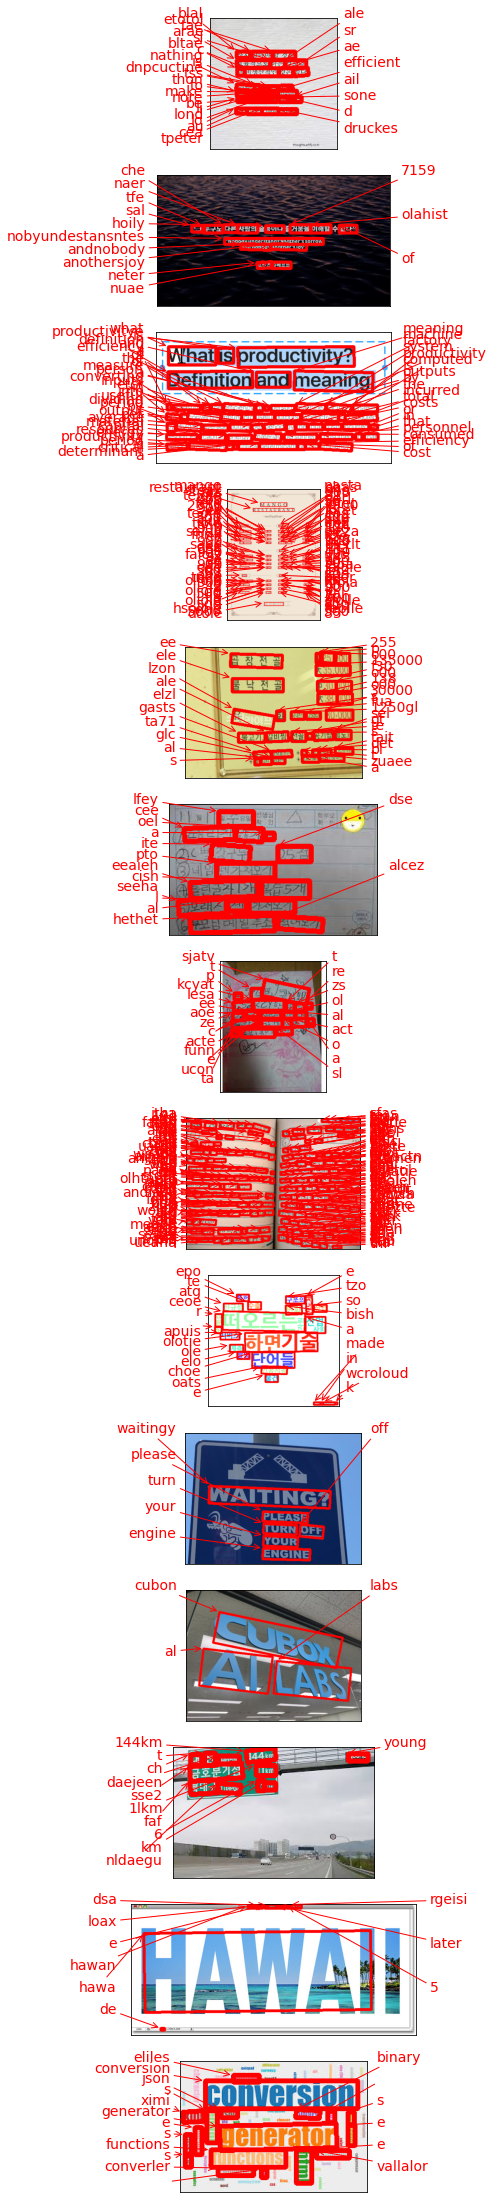

In [18]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 40))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

- 한글 텍스트는 예상대로 detection은 되지만 recognition은 전혀 다르게 나온다.
- 텍스트 색상이 배경과 반전되어 있어도 잘 감지하는지 궁금했는데 제대로 동작한다.
- 근데 영어 텍스트 인식도 대체로 Google OCR API보다 떨어지는 것 같다.

## 3) Tesseract (테서렉트)

In [19]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

In [20]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [21]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [14]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/cropped'

for file in file_list:
    path = os.path.join(img_dir, file)
    print(path)
    cropped_image_path_list = crop_word_regions(os.path.join(img_dir, file), work_dir)
    recognize_images(cropped_image_path_list)
    print("-"*79)

/aiffel/aiffel/ocr_python/images/1.jpg
/aiffel/aiffel/ocr_python/cropped/0000.png
/aiffel/aiffel/ocr_python/cropped/0001.png
/aiffel/aiffel/ocr_python/cropped/0002.png
/aiffel/aiffel/ocr_python/cropped/0003.png
/aiffel/aiffel/ocr_python/cropped/0004.png
/aiffel/aiffel/ocr_python/cropped/0005.png
/aiffel/aiffel/ocr_python/cropped/0006.png
/aiffel/aiffel/ocr_python/cropped/0007.png
/aiffel/aiffel/ocr_python/cropped/0008.png
/aiffel/aiffel/ocr_python/cropped/0009.png
/aiffel/aiffel/ocr_python/cropped/0010.png
/aiffel/aiffel/ocr_python/cropped/0011.png
/aiffel/aiffel/ocr_python/cropped/0012.png
/aiffel/aiffel/ocr_python/cropped/0013.png
/aiffel/aiffel/ocr_python/cropped/0014.png
/aiffel/aiffel/ocr_python/cropped/0015.png
/aiffel/aiffel/ocr_python/cropped/0016.png
/aiffel/aiffel/ocr_python/cropped/0017.png
/aiffel/aiffel/ocr_python/cropped/0018.png
/aiffel/aiffel/ocr_python/cropped/0019.png
/aiffel/aiffel/ocr_python/cropped/0020.png
/aiffel/aiffel/ocr_python/cropped/0021.png
/aiffel/aiffel/

In [60]:
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [61]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/cropped'

for file in file_list:
    path = os.path.join(img_dir, file)
    print(path)
    cropped_image_path_list = crop_word_regions(os.path.join(img_dir, file), work_dir)
    recognize_images(cropped_image_path_list)
    print("-"*79)

/aiffel/aiffel/ocr_python/images/1.jpg
/aiffel/aiffel/ocr_python/cropped/0000.png
/aiffel/aiffel/ocr_python/cropped/0001.png
/aiffel/aiffel/ocr_python/cropped/0002.png
/aiffel/aiffel/ocr_python/cropped/0003.png
/aiffel/aiffel/ocr_python/cropped/0004.png
/aiffel/aiffel/ocr_python/cropped/0005.png
/aiffel/aiffel/ocr_python/cropped/0006.png
/aiffel/aiffel/ocr_python/cropped/0007.png
/aiffel/aiffel/ocr_python/cropped/0008.png
/aiffel/aiffel/ocr_python/cropped/0009.png
/aiffel/aiffel/ocr_python/cropped/0010.png
/aiffel/aiffel/ocr_python/cropped/0011.png
/aiffel/aiffel/ocr_python/cropped/0012.png
/aiffel/aiffel/ocr_python/cropped/0013.png
/aiffel/aiffel/ocr_python/cropped/0014.png
/aiffel/aiffel/ocr_python/cropped/0015.png
/aiffel/aiffel/ocr_python/cropped/0016.png
/aiffel/aiffel/ocr_python/cropped/0017.png
/aiffel/aiffel/ocr_python/cropped/0018.png
/aiffel/aiffel/ocr_python/cropped/0019.png
/aiffel/aiffel/ocr_python/cropped/0020.png
/aiffel/aiffel/ocr_python/cropped/0021.png
/aiffel/aiffel/

- recognize_images함수에서 lang='eng'으로 하여 영어만 제대로 인식하도록 했다.
- 영어 텍스트 인식도 Google OCR API보다 떨어지는 것 같다.

# Step3. 테스트 결과 정리

In [42]:
def test_result(img_path, idx):
   
    print("-"*79)
    print("Google OCR")
    detect_text(img_path)
    print("-"*79)
    print("keras-ocr")
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0])
    plt.show()
    print("-"*79)
    print("Tesseract")
    work_dir = os.getenv('HOME')+'/aiffel/ocr_python/cropped'
    cropped_image_path_list=crop_word_regions(img_path, work_dir)
    recognize_images(cropped_image_path_list)

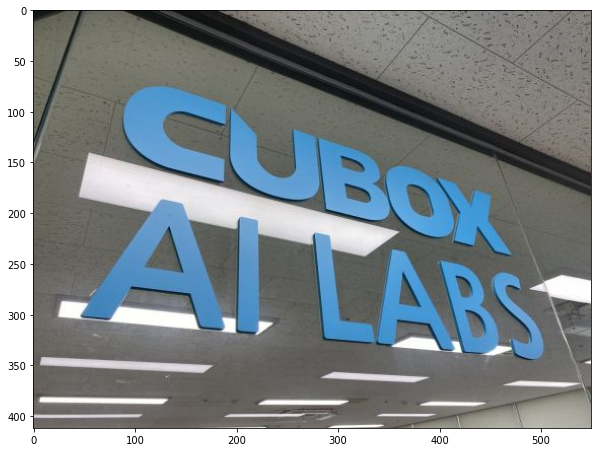

In [43]:
img_path = os.path.join(img_dir, file_list[10])
plt.figure(figsize=(10,10))
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

-------------------------------------------------------------------------------
Google OCR
Texts:

"CUBOX
ALLABS
"

"CUBOX"

"ALLABS"
bounds: (48,162),(529,241),(507,373),(26,294)
-------------------------------------------------------------------------------
keras-ocr


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


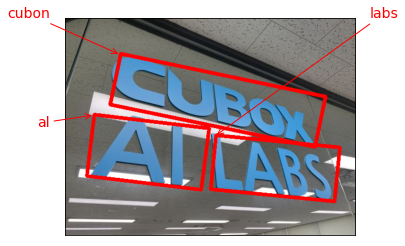

-------------------------------------------------------------------------------
Tesseract
/aiffel/aiffel/ocr_python/cropped/0000.png
payer

Done


In [45]:
test_result(img_path,10)

-------------------------------------------------------------------------------
Google OCR
Texts:

"CUBOX
ALLABS
"

"CUBOX"

"ALLABS"
bounds: (48,162),(529,241),(507,373),(26,294)
-------------------------------------------------------------------------------
keras-ocr


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


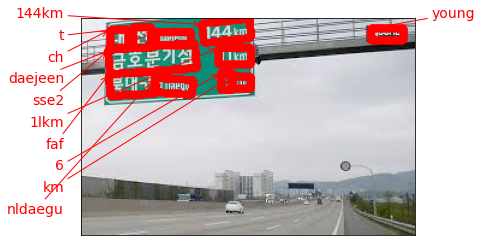

-------------------------------------------------------------------------------
Tesseract
/aiffel/aiffel/ocr_python/cropped/0000.png
payer

Done


In [46]:
test_result(img_path,11)

-------------------------------------------------------------------------------
Google OCR
Texts:

"CUBOX
ALLABS
"

"CUBOX"

"ALLABS"
bounds: (48,162),(529,241),(507,373),(26,294)
-------------------------------------------------------------------------------
keras-ocr


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


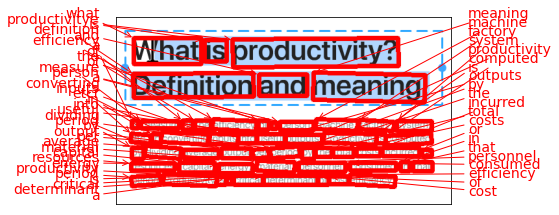

-------------------------------------------------------------------------------
Tesseract
/aiffel/aiffel/ocr_python/cropped/0000.png
payer

Done


In [49]:
test_result(img_path,2)

# 루브릭
1.OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?
- 목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.

2.모델 평가기준이 명확하고 체계적으로 세워졌는가?
- 평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.

3.평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?
- 최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.

# 회고

한국어, 영어를 포함한 다양한 이미지를 테스트 이미지로 사용했다. google api로는 인식이 되던 이미지가 keras-ocr에서 오류가 발생해서 알아보니 gif파일에서 변환한 jpg파일이 원인이었다.